In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import stats
from scipy.stats import hmean
from scipy.stats import skewnorm
import pickle
from scipy.special import binom, comb
import math

def rolling_mean(array,window):
    return_data=[]
    for i in range(len(array)-window+1):
        window_data = array[i:i+window]
        return_data.append(stats.mstats.gmean(window_data))
    return return_data

def rolling_harmonic_mean(array,window):
    return_data=[]
    for i in range(len(array)-window+1):
        window_data = array[i:i+window]
        return_data.append(hmean(window_data))
    return return_data

def kmer_mean(array1,array2,window):
    return_data=[]
    for i in range(len(array1)-window+1):
        window_data1 = array1[i:i+window]
        window_data2 = array2[i:i+window]
        return_data.append(np.sum(window_data1)/np.sum(window_data2))
    return return_data

def rolling_arithmetic_mean(array,window):    
    return_data=[]
    for i in range(len(array)-window+1):
        window_data = array[i:i+window]
        return_data.append(np.mean(window_data))
    return return_data

#returns the probability of decoding a given block with some 1-p_index_exists probability of erasures
def block_probability(block_size,data_strands,ECC_overhead_strands,p_index_exists):
    sum_probabilities = 0
    for k in range(data_strands):
        sum_probabilities+=comb(block_size,k,exact=True)*(p_index_exists**k)*(1-p_index_exists)**(block_size-k)
    return 1-sum_probabilities

#takes in a dictionary of points and finds labeled points that provide optimal choices
def generate_segments(line_dict):
    labeled_points = [(x[0],x[1],z) for z in line_dict for x in line_dict[z]]
    sorted_labeled_points = sorted(labeled_points,key=lambda x: (x[1],x[0]),reverse=True)
    #now we have all points with one axis arranged largest to smallest
    frontier=[]
    frontier.append(sorted_labeled_points[0])
    sorted_labeled_points=sorted_labeled_points[1::]
    while len(sorted_labeled_points)>0:
        best_point=None
        best_index=None
        for i,p in enumerate(sorted_labeled_points):
            if p[1]<frontier[-1][1] and p[0]>frontier[-1][0]:
                if best_point is None or (p[0]>=best_point[0] and p[1]>=best_point[1]):
                    best_point=p
                    best_index=i
        if best_point is None:
            break
        else:
            frontier.append(best_point)
            sorted_labeled_points= sorted_labeled_points[best_index::]
    #frontier is now known
    frontier_dict={}
    for p in frontier:
        if p[2] not in frontier_dict:
            frontier_dict[p[2]]=[(p[0],p[1])]
        else:
            frontier_dict[p[2]].append((p[0],p[1]))
    return frontier_dict
    
def calculate_outer_code(p_index_exists,file_size,bytes_per_strand,d=1,strand_length=0,target_MTTF=10**6):
    MTTF=0
    ECC_overhead=0
    block_size=255
    total_strands=0
    while MTTF<target_MTTF and total_strands < 256**index_bytes and ECC_overhead<block_size:
        data_strands = block_size-ECC_overhead
        block_bytes = data_strands*bytes_per_strand
        total_blocks = int(math.ceil(file_size/block_bytes))
        #for each coverage, determine the outer code so a file F with X blocks of 256 strands can be decoded with MTTF of 1M reads
        p_block = block_probability(block_size,data_strands,ECC_overhead,p_index_exists)
        if 1-(p_block)==0:
            MTTF=float('inf')
        else:
            MTTF = 1/(1-(p_block)**total_blocks)
        last_ECC = ECC_overhead
        ECC_overhead+=1
    if MTTF>=target_MTTF:
        #able to successfully find a configuration
        total_strands = (total_blocks*block_size)-(block_size-int(math.ceil((file_size%block_bytes)/bytes_per_strand)))
        #calculate a density to make comparison equivalent
        final_density = file_size*8/(total_strands*strand_length)
        read_density = file_size*8/(total_strands*d*strand_length)
        return read_density,final_density
    else:
        return None,None

In [2]:
pd.set_option('display.max_columns', None)
bio_data = pd.read_pickle("framed_iid.pickle")
nano_data=pd.read_pickle("framed_DNArSim.pickle")
bio_data = bio_data.replace(r'^\s*$', None, regex=True)
nano_data=nano_data.replace(r'^\s*$',None,regex=True)

#Split RS and HEDGES dataframes, dataframes are also separated to only include ideal clustering
RS_cluster_ideal = bio_data[(bio_data["arch"]=="ReedSolomon_Base4_Pipeline") &(bio_data["encoder::using_DNA_consolidator"]=="ideal") & (bio_data["fault_rate"]!=0.15)]
#print(RS_cluster_ideal[RS_cluster_ideal["payload::inner_rs::total_strands"]<10000][["payload::inner_rs::total_strands","encoder::packeted_inner_strand_size"]])
#print(np.sum(RS_cluster_ideal["payload::inner_rs::total_strands"]))

print("===========RS_cluster_ideal=============") 
print("Total experiments {}".format(len(RS_cluster_ideal)))
print("Min strands per inner code {}".format(min(RS_cluster_ideal["payload::inner_rs::total_strands"])))
print("Total strands analyzed across experiments {}".format(sum(RS_cluster_ideal["total_strands_analyzed"])))
print("Smallest strand length in bases {}".format(min(RS_cluster_ideal["payload_strand_length"])))
print("Largest strand length in bases {}".format(max(RS_cluster_ideal["payload_strand_length"])))


print("===========Hedges_cluster_ideal=============") 
Hedges_cluster_ideal = bio_data[(bio_data["arch"]=="BasicHedges") &(bio_data["encoder::using_DNA_consolidator"]=="ideal") & (bio_data["fault_rate"]!=0.15) &(bio_data["payload_strand_length"]<250)]
print("Total experiments {}".format(len(Hedges_cluster_ideal)))
print("Min strands per inner code {}".format(min(Hedges_cluster_ideal["payload::hedges::total_strands"])))
print("Total strands analyzed across experiments {}".format(sum(Hedges_cluster_ideal["total_strands_analyzed"])))
print("Smallest strand length in bases {}".format(min(Hedges_cluster_ideal["payload_strand_length"])))
print("Largest strand length in bases {}".format(max(Hedges_cluster_ideal["payload_strand_length"])))



print("===========Hedges_no_cluster=============") 
Hedges_no_cluster =  bio_data[(bio_data["arch"]=="BasicHedges") &(bio_data["encoder::using_DNA_consolidator"]==False)&(bio_data["fault_rate"]!=0.15)&(bio_data["payload_strand_length"]<250)]
print("Total experiments {}".format(len(Hedges_no_cluster)))
print("Min strands per inner code {}".format(min(Hedges_no_cluster["payload::hedges::total_strands"])))
print("Total strands analyzed across experiments {}".format(sum(Hedges_no_cluster["total_strands_analyzed"])))
print("Smallest strand length in bases {}".format(min(Hedges_no_cluster["payload_strand_length"])))
print("Largest strand length in bases {}".format(max(Hedges_no_cluster["payload_strand_length"])))


print("===========RS_cluster_ideal DNArSim=============") 
#Get Data for nanopore runs
RS_cluster_ideal_nano = nano_data[(nano_data["arch"]=="ReedSolomon_Base4_Pipeline") &(nano_data["encoder::using_DNA_consolidator"]=="ideal")]
print("Total experiments {}".format(len(RS_cluster_ideal_nano)))
print("Min strands per inner code {}".format(min(RS_cluster_ideal_nano["payload::inner_rs::total_strands"])))
print("Total strands analyzed across experiments {}".format(sum(RS_cluster_ideal_nano["total_strands_analyzed"])))
print("Smallest strand length in bases {}".format(min(RS_cluster_ideal_nano["payload_strand_length"])))
print("Largest strand length in bases {}".format(max(RS_cluster_ideal_nano["payload_strand_length"])))

print("===========Hedges_cluster_ideal DNArSim=============") 
Hedges_cluster_ideal_nano = nano_data[(nano_data["arch"]=="BasicHedges") &(nano_data["encoder::using_DNA_consolidator"]=="ideal")&(nano_data["payload_strand_length"]<250)]
print("Total experiments {}".format(len(Hedges_cluster_ideal_nano)))
print("Min strands per inner code {}".format(min(Hedges_cluster_ideal_nano["payload::hedges::total_strands"])))
print("Total strands analyzed across experiments {}".format(sum(Hedges_cluster_ideal_nano["total_strands_analyzed"])))
print("Smallest strand length in bases {}".format(min(Hedges_cluster_ideal_nano["payload_strand_length"])))
print("Largest strand length in bases {}".format(max(Hedges_cluster_ideal_nano["payload_strand_length"])))

print("===========Hedges_basic DNArSim=============") 
Hedges_no_cluster_nano =  nano_data[(nano_data["arch"]=="BasicHedges") &(nano_data["encoder::using_DNA_consolidator"]==False)&(nano_data["payload_strand_length"]<250)]
print("Total experiments {}".format(len(Hedges_no_cluster_nano)))
print("Min strands per inner code {}".format(min(Hedges_no_cluster_nano["payload::hedges::total_strands"])))
print("Total strands analyzed across experiments {}".format(sum(Hedges_no_cluster_nano["total_strands_analyzed"])))
print("Smallest strand length in bases {}".format(min(Hedges_no_cluster_nano["payload_strand_length"])))
print("Largest strand length in bases {}".format(max(Hedges_no_cluster_nano["payload_strand_length"])))



===========RS_cluster_ideal=============
Total experiments 84
Min strands per inner code 51200.0
Total strands analyzed across experiments 91901952
Smallest strand length in bases 240
Largest strand length in bases 240
===========Hedges_cluster_ideal=============
Total experiments 84
Min strands per inner code 73728.0
Total strands analyzed across experiments 395476992
Smallest strand length in bases 240
Largest strand length in bases 242
===========Hedges_no_cluster=============
Total experiments 12
Min strands per inner code 73728.0
Total strands analyzed across experiments 3661824
Smallest strand length in bases 240
Largest strand length in bases 242
===========RS_cluster_ideal DNArSim=============
Total experiments 28
Min strands per inner code 51200.0
Total strands analyzed across experiments 30633984
Smallest strand length in bases 240
Largest strand length in bases 240
===========Hedges_cluster_ideal DNArSim=============
Total experiments 28
Min strands per inner code 73728.0
To

## Basic Error Distribution

In [33]:
#For Reed-solomon pick a design and look at the MSA error rates
cluster_data = RS_cluster_ideal[(RS_cluster_ideal["encoder::packeted_inner_strand_size"].apply(lambda x:x==[6,51]))]
cluster_data=cluster_data.fillna(value=0)
for fault_rate in set(cluster_data["fault_rate"]):
    print(fault_rate)
    cluster_data_fault_rate = cluster_data[cluster_data["fault_rate"]==fault_rate]
    row_data=[]
    for index, row in cluster_data_fault_rate.iterrows():
        total_edit_error_array = row["payload::post_cluster::total_edit_errors"]
        total_ed_strands = row["payload::post_cluster::ed_total_strands"]
        n_reads = row["n_success"]
        total_bases = total_ed_strands*row["payload_strand_length"]
        total_errors = np.sum(total_edit_error_array)
        row_data.append((n_reads,total_errors/total_bases))
    row_data=sorted(row_data,key=lambda x: x[0])
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(list(zip(*row_data))[0],list(zip(*row_data))[1],linewidth=2.4,
         label="")
    plt.xlabel("Reads Per Strand")
    plt.ylabel("Error Rate")
    plt.title("Base Error Rate vs. Number of MSA Strands")
    plt.show()


### RS Strand Error Rates after MSA

0.05
(0, 56)
[0.01519531 0.2609375  0.87810547 0.97142578 0.60191406 0.69734375
 0.74890625]
(9, 47)
[0.05973307 0.3398763  0.88787435 0.9730957  0.66028646 0.7336263
 0.78333333]
(14, 42)
[0.07974289 0.3594333  0.88781192 0.97277285 0.66506821 0.7349726
 0.78591418]
(28, 28)
[0.12689453 0.40239258 0.89396484 0.97439453 0.67931641 0.74791992
 0.79383789]
0.1
(0, 56)
[0.         0.00208984 0.23476562 0.56308594 0.07998047 0.12830078
 0.17234375]
(9, 47)
[2.27864583e-04 1.70898438e-02 3.16959635e-01 6.00569661e-01
 1.45100911e-01 1.98242188e-01 2.44938151e-01]
(14, 42)
[0.00107859 0.02883046 0.33322645 0.60775711 0.16194904 0.21430445
 0.2591243 ]
(28, 28)
[0.00631836 0.06095703 0.36587891 0.62507812 0.19738281 0.25421875
 0.29708984]
0.01
(0, 56)
[0.78787109 0.97775391 0.99990234 1.         0.97853516 0.988125
 0.99314453]
(9, 47)
[0.8195638  0.97830404 0.99991862 1.         0.98024089 0.98977865
 0.9941569 ]
(14, 42)
[0.82520989 0.97997318 0.99985424 1.         0.98230527 0.99046758
 0

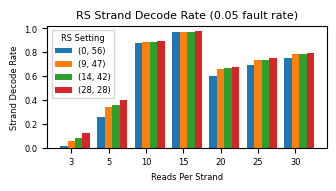

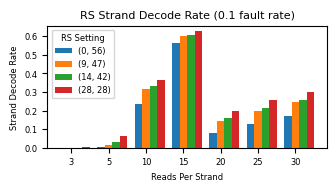

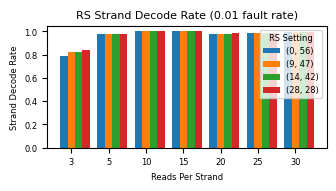

In [34]:
#Calculate Strand Error Rates for RS Codes
#Each plot is for a fault rate, x-axis is read depth, y-axis is strand error rate, lines are for a given RS configuration
bar_width=0.2
#For Reed-solomon pick a design and look at the MSA error rates
for fault_rate in set(RS_cluster_ideal["fault_rate"]):
    print(fault_rate)
    cluster_data = RS_cluster_ideal[RS_cluster_ideal["fault_rate"]==fault_rate]
    fig,axes = plt.subplots(1,1,figsize=(3.25,1.8),layout="constrained")
    for RS_index,RS_setting in enumerate(sorted(set(cluster_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))),key=lambda x:x[0])):
        if RS_setting == tuple([56,1]): continue
        print(RS_setting)
        cluster_data_2 = cluster_data[(cluster_data["encoder::packeted_inner_strand_size"].apply(lambda x:tuple(x)==RS_setting))]
        cluster_data_2=cluster_data_2.fillna(value=0)
        row_data=[]
        for index, row in cluster_data_2.iterrows():
            total_strand_errors =  row["payload::inner_rs::incorrect_strands"]
            total_strands = row["payload::inner_rs::total_strands"]
            n_reads = row["n_success"]
            row_data.append((n_reads,total_strand_errors/total_strands))
        row_data=sorted(row_data,key=lambda x: x[0])
        average_bytes_per_strand = np.array([1-r[1] for r in row_data])
        print(average_bytes_per_strand)
        #print(average_bytes_per_strand)
        #average_bytes_per_strand=average_bytes_per_strand*RS_setting[1]
        index = np.arange(len(row_data))
        axes.bar(index+bar_width*RS_index,average_bytes_per_strand,bar_width,label="{}".format(RS_setting))
        axes.set_xticks(index + bar_width, [r[0] for r in row_data])

    axes.set_xlabel("Reads Per Strand",fontsize=6)
    axes.set_ylabel("Strand Decode Rate",fontsize=6)
    axes.legend(title="RS Setting",fontsize=6,title_fontsize=6)
    axes.set_title("RS Strand Decode Rate ({} fault rate)".format(fault_rate),fontsize=8)
    axes.tick_params(axis='both',which='major',labelsize=6)
    if fault_rate==0.05:
        
        fig.savefig("strand_efficiency_{}.pdf".format(fault_rate),format="pdf")


### Hedges MSA Error Rates

0.05
0.1
0.01


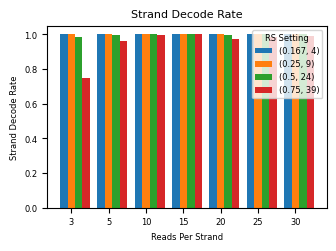

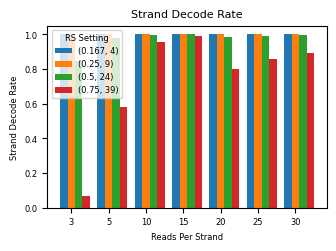

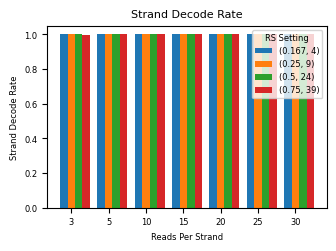

In [35]:
#Calculate Strand Error Rates for RS Codes
#Each plot is for a fault rate, x-axis is read depth, y-axis is strand error rate, lines are for a given RS configuration
bar_width=0.2
#For Reed-solomon pick a design and look at the MSA error rates
for fault_rate in set(Hedges_cluster_ideal["fault_rate"]):
    print(fault_rate)
    cluster_data = Hedges_cluster_ideal[Hedges_cluster_ideal["fault_rate"]==fault_rate]
    fig,axes = plt.subplots(1,1,figsize=(3.25,2.4),layout="constrained")
    for RS_index,RS_setting in enumerate(sorted(set(cluster_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))),key=lambda x:x[0])):
        if RS_setting == tuple([56,1]): continue
        cluster_data_2 = cluster_data[(cluster_data["encoder::packeted_inner_strand_size"].apply(lambda x:tuple(x)==RS_setting))]
        cluster_data_2=cluster_data_2.fillna(value=0)
        row_data=[]
        for index, row in cluster_data_2.iterrows():
            total_strand_errors =  row["payload::hedges::incorrect_strands"]
            total_strands = row["payload::hedges::total_strands"]
            n_reads = row["n_success"]
            #print(1-(total_strand_errors)/total_strands)
            row_data.append((n_reads,total_strand_errors/total_strands))
        row_data=sorted(row_data,key=lambda x: x[0])
        average_bytes_per_strand = np.array([1-r[1] for r in row_data])
        #print(average_bytes_per_strand)
        #average_bytes_per_strand=average_bytes_per_strand*RS_setting[1]
        index = np.arange(len(row_data))
        axes.bar(index+bar_width*RS_index,average_bytes_per_strand,bar_width,label="{}".format(RS_setting))
        axes.set_xticks(index + bar_width, [r[0] for r in row_data])

    axes.set_xlabel("Reads Per Strand",fontsize=6)
    axes.set_ylabel("Strand Decode Rate",fontsize=6)
    axes.legend(title="RS Setting",fontsize=6,title_fontsize=6)
    axes.set_title("Strand Decode Rate",fontsize=8)
    axes.tick_params(axis='both',which='major',labelsize=6)

In [36]:
combined_frontier={}

### Hedges, No MSA

0.05
(0.25, 9)
0.9994469306229773
(0.167, 4)
0.9999423898381294
(0.5, 24)
0.9511971309267241
(0.75, 39)
0.13871256510416666


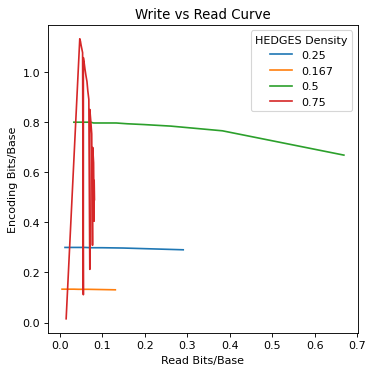

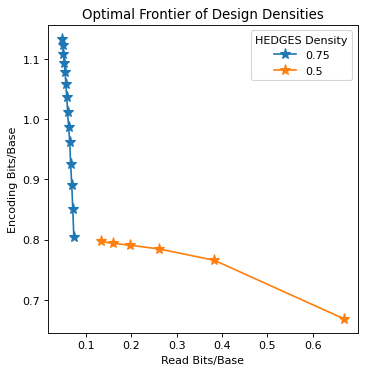

0.1
(0.25, 9)
0.9961695995145631
(0.167, 4)
0.9997667491007194
(0.5, 24)
0.5200447871767241
(0.75, 39)
0.00018988715277777778


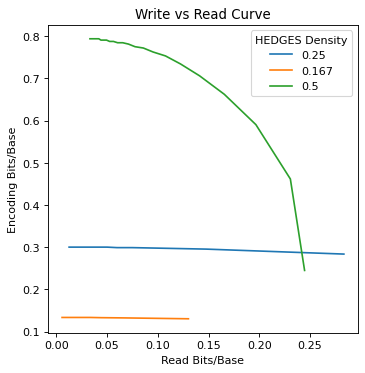

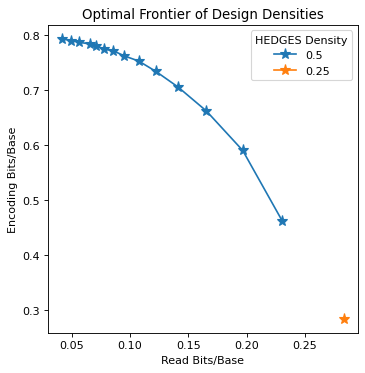

0.01
(0.25, 9)
0.9999146692961165
(0.167, 4)
0.9999831384892086
(0.5, 24)
0.9975670123922413
(0.75, 39)
0.922119140625


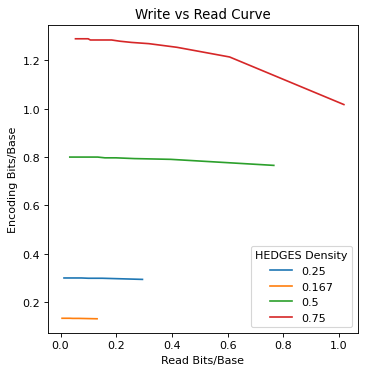

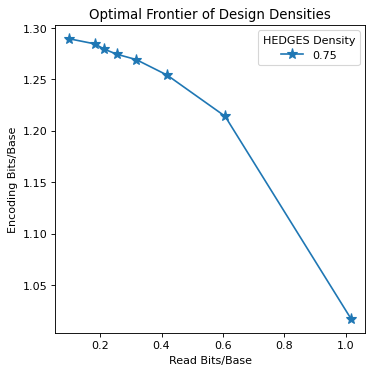

In [37]:

#Write Cost vs Read Cost Curves for Hedges without Clustering, need to determine how much ECC for a given D
p_no_drop_out = 1.0
file_size = 1*10**6 #start with 1 MB files
for fault_rate in set(Hedges_no_cluster["fault_rate"]):
    print(fault_rate)
    fault_rate_data = Hedges_no_cluster[Hedges_no_cluster["fault_rate"]==fault_rate]
    plt.figure(figsize=(5, 5), dpi=80)
    h_rate_dict={}
    for h_rate in set(fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))):
        print(h_rate)
        hedges_data = fault_rate_data[fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x :tuple(x)==h_rate)]
        write_read_curve=[]
        #if h_rate[0]!=0.5: continue
        for index, row in hedges_data.iterrows():
            #get rates of success for strand level
            success_rate = row["payload::hedges::correct_strands"]
            total_strands_hedges =row["payload::hedges::total_strands"]
            index_bytes = row["encoder::index_bytes"]
            strand_length = row["payload_strand_length"]
            bytes_per_strand = h_rate[1]
            decode_rate = success_rate/total_strands_hedges
            print(decode_rate)
            ideal_strands = int(math.ceil(file_size/bytes_per_strand))
            #sweep over coverage, determine probability that index exists
            for d in range(1,25):
                p_index_exists  = (1-(1-decode_rate)**d)*p_no_drop_out
                read_density,write_density=calculate_outer_code(p_index_exists,file_size,bytes_per_strand,strand_length=strand_length,d=d,target_MTTF=10**9)
                if read_density!=None:
                    #print((d,write_density))
                    write_read_curve.append((read_density,write_density))
            write_read_curve = sorted(write_read_curve,key=lambda x: x[0])
            if len(write_read_curve)==0: continue
            plt.plot(list(zip(*write_read_curve))[0],list(zip(*write_read_curve))[1],linewidth=1.5,
             label="{}".format(h_rate[0]))
            h_rate_dict[h_rate[0]]=write_read_curve
    plt.xlabel("Read Bits/Base")
    plt.ylabel("Encoding Bits/Base")
    segments = generate_segments(h_rate_dict)
    combined_frontier[fault_rate]={}
    combined_frontier[fault_rate]["HEDGES"]=segments
    plt.legend(title="HEDGES Density")
    plt.title("Write vs Read Curve")
    plt.show()
    #plot Frontiers for each error rate
    plt.figure(figsize=(5, 5), dpi=80)
    for s in segments:
        points=segments[s]
        plt.plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1.5,
                 marker='*',markersize=10,label="{}".format(s))
    plt.title("Optimal Frontier of Design Densities")
    plt.xlabel("Read Bits/Base")
    plt.ylabel("Encoding Bits/Base")
    plt.legend(title="HEDGES Density")
    plt.show()
    #determine optimal segments for each fault rate
   

### RS MSA

0.05


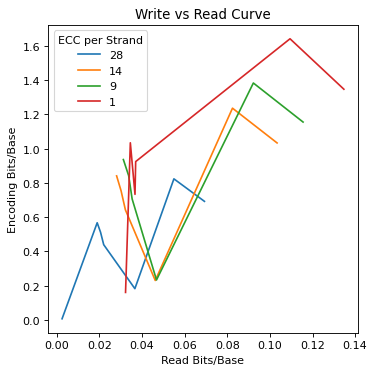

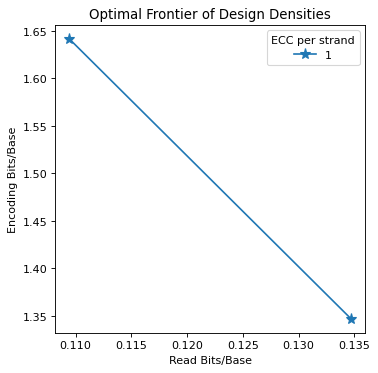

0.1


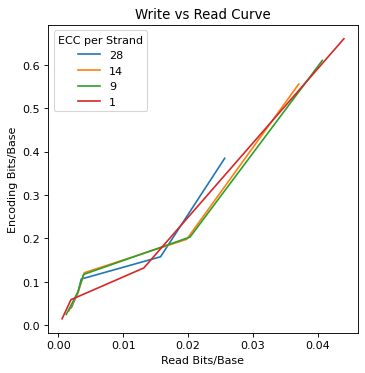

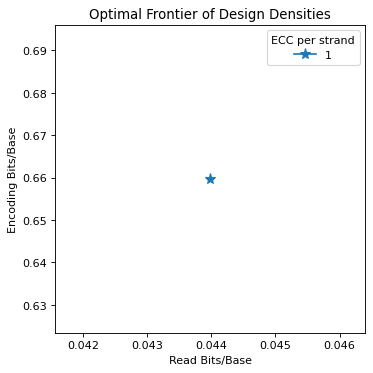

0.01


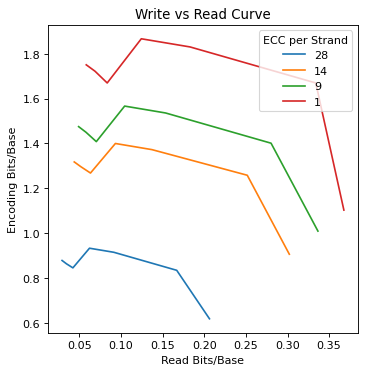

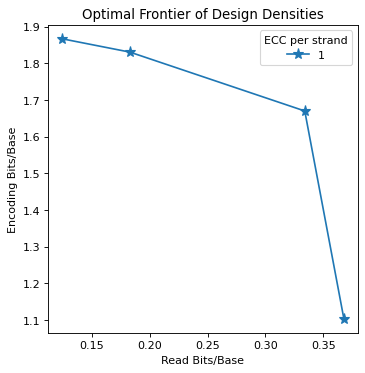

In [38]:
#Write Cost vs Read Cost Curves for Reed Solomon, need to determine how much ECC for a given D
for fault_rate in set(RS_cluster_ideal["fault_rate"]):
    print(fault_rate)
    fault_rate_data = RS_cluster_ideal[RS_cluster_ideal["fault_rate"]==fault_rate]
    plt.figure(figsize=(5, 5), dpi=80)
    rs_rate_dict={}
    for rs_rate in set(fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))):
        rs_data = fault_rate_data[fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x :tuple(x)==rs_rate)]
        write_read_curve=[]
        for d in sorted(set(rs_data["n_success"])):
            d_data = rs_data[rs_data["n_success"]==d]
            for index, row in d_data.iterrows():
                #get rates of success for strand level
                success_rate = row["payload::inner_rs::correct_strands"]
                total_strands =row["payload::inner_rs::total_strands"]
                index_bytes = row["encoder::index_bytes"]
                strand_length = row["payload_strand_length"]
                bytes_per_strand = rs_rate[1]
                if rs_rate[0]==0:
                    bytes_per_strand-=1 #This accounts for detection, 
                    rs_rate=(1,rs_rate[1])
                decode_rate = success_rate/total_strands
                ideal_strands = int(math.ceil(file_size/bytes_per_strand))
                #sweep over coverage, determine probability that index exists
                p_index_exists  = (1-(1-decode_rate))*p_no_drop_out
                read_density,write_density=calculate_outer_code(p_index_exists,file_size,bytes_per_strand,strand_length=strand_length,d=d,target_MTTF=10**9)
                if read_density !=None:
                    write_read_curve.append((read_density,write_density))
        if len(write_read_curve)==0: continue 
        write_read_curve = sorted(write_read_curve,key=lambda x: x[0])
        plt.plot(list(zip(*write_read_curve))[0],list(zip(*write_read_curve))[1],linewidth=1.5,
         label="{}".format(rs_rate[0]))
        rs_rate_dict[rs_rate[0]]=write_read_curve
    plt.xlabel("Read Bits/Base")
    plt.ylabel("Encoding Bits/Base")
    plt.legend(title="ECC per Strand")
    plt.title("Write vs Read Curve")
    plt.show()
    if len(rs_rate_dict)==0: continue
    segments = generate_segments(rs_rate_dict)
    combined_frontier[fault_rate]["RS"]=segments
    #plot Frontiers for each error rate
    plt.figure(figsize=(5, 5), dpi=80)
    for s in segments:
        points=segments[s]
        plt.plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1.5,
                 marker='*',label="{}".format(s),markersize=10)
    plt.title("Optimal Frontier of Design Densities")
    plt.xlabel("Read Bits/Base")
    plt.ylabel("Encoding Bits/Base")
    plt.legend(title="ECC per strand")
    plt.show()
    #determine optimal segments for each fault rate
   

### Hedges MSA

0.05


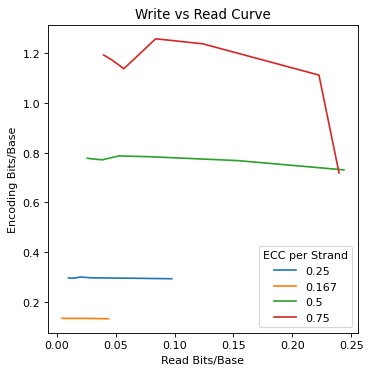

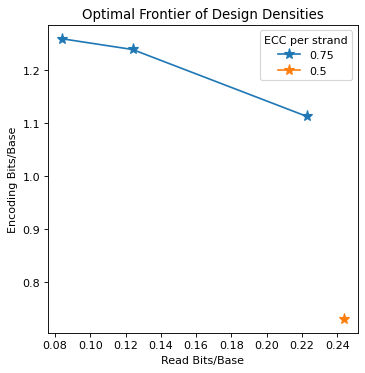

0.1


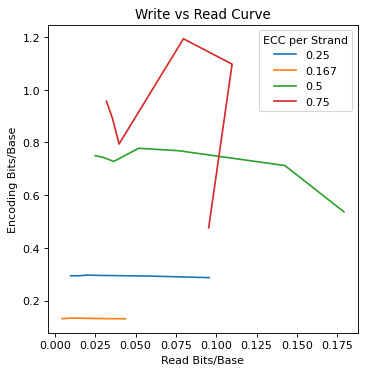

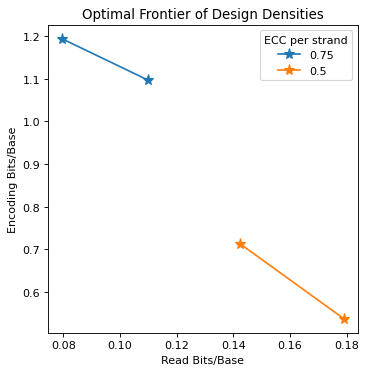

0.01


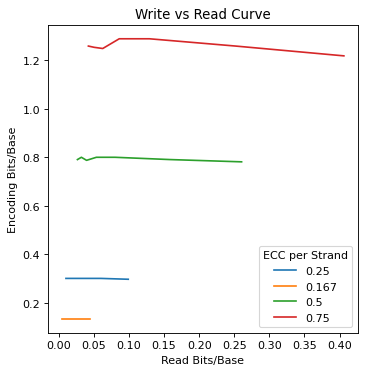

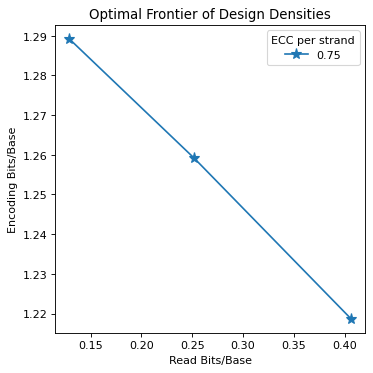

In [39]:
#Write Cost vs Read Cost Curves for Hedges with ideal Clusterin, need to determine how much ECC for a given D
for fault_rate in set(Hedges_cluster_ideal["fault_rate"]):
    print(fault_rate)
    fault_rate_data = Hedges_cluster_ideal[Hedges_cluster_ideal["fault_rate"]==fault_rate]
    plt.figure(figsize=(5, 5), dpi=80)
    rs_rate_dict={}
    for rs_rate in set(fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))):
        rs_data = fault_rate_data[fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x :tuple(x)==rs_rate)]
        write_read_curve=[]
        for d in sorted(set(rs_data["n_success"])):
            d_data = rs_data[rs_data["n_success"]==d]
            for index, row in d_data.iterrows():
                #get rates of success for strand level
                success_rate = row["payload::hedges::correct_strands"]
                total_strands =row["payload::hedges::total_strands"]
                index_bytes = row["encoder::index_bytes"]
                strand_length = row["payload_strand_length"]
                bytes_per_strand = rs_rate[1]
                decode_rate = success_rate/total_strands
                ideal_strands = int(math.ceil(file_size/bytes_per_strand))
                #sweep over coverage, determine probability that index exists
                p_index_exists  = (1-(1-decode_rate))*p_no_drop_out
                read_density,write_density=calculate_outer_code(p_index_exists,file_size,bytes_per_strand,strand_length=strand_length,d=d,target_MTTF=10**9)
                if read_density!=None:
                    write_read_curve.append((read_density,write_density))
        if len(write_read_curve)==0: continue 
        plt.plot(list(zip(*write_read_curve))[0],list(zip(*write_read_curve))[1],linewidth=1.5,
         label="{}".format(rs_rate[0]))
        rs_rate_dict[rs_rate[0]]=write_read_curve
    plt.xlabel("Read Bits/Base")
    plt.ylabel("Encoding Bits/Base")
    if len(rs_rate_dict)==0: continue
    segments = generate_segments(rs_rate_dict)
    combined_frontier[fault_rate]["Hedges-MSA"]=segments
    plt.legend(title="ECC per Strand")
    plt.title("Write vs Read Curve")
    plt.show()
    #plot Frontiers for each error rate
    plt.figure(figsize=(5, 5), dpi=80)
    for s in segments:
        points=segments[s]
        plt.plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1.5,
                 marker='*',label="{}".format(s),markersize=10)
    plt.title("Optimal Frontier of Design Densities")
    plt.xlabel("Read Bits/Base")
    plt.ylabel("Encoding Bits/Base")
    plt.legend(title="ECC per strand")
    plt.show()
    #determine optimal segments for each fault rate
   

### Calculate Total Frontiers

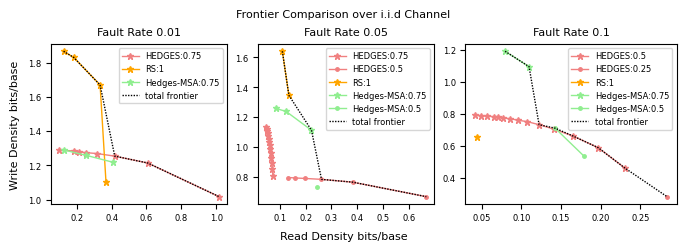

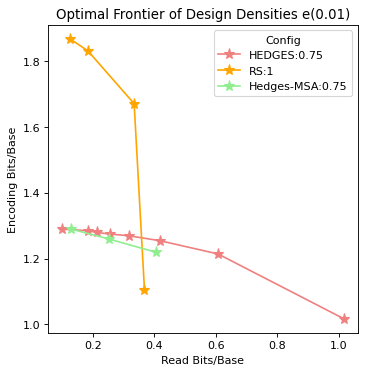

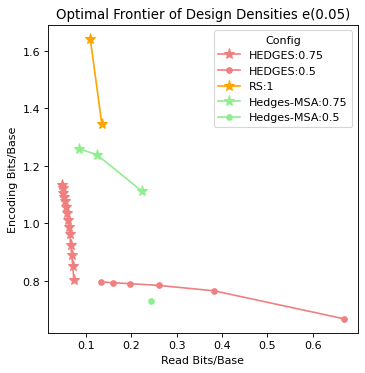

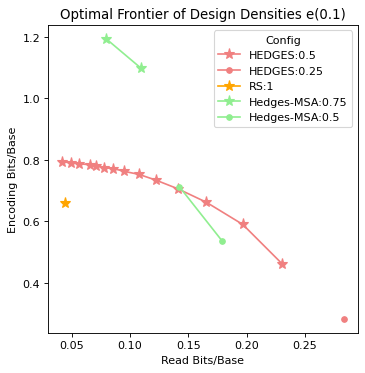

In [40]:
#plot combined frontier
colors = ['lightcoral','orange','lightgreen']
marker = ['*','.','^']
fig_fontsize=6
fig,axes = plt.subplots(1,3,figsize=(6.75,2.4),layout="constrained",gridspec_kw={'width_ratios': [1, 1, 1.2]})
for fault_index,fault_rate in enumerate(sorted(combined_frontier)):
    if fault_index>=len(axes): break
    total_points_dict={"total frontier":[]}
    plt.figure(figsize=(5, 5), dpi=80)
    for t_index ,t in enumerate(combined_frontier[fault_rate]):
        for f_index, f in enumerate(combined_frontier[fault_rate][t]):
            points = combined_frontier[fault_rate][t][f]
            total_points_dict["total frontier"]+=points
            axes[fault_index].plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1, label="{}:{}".format(t,f),color=colors[t_index],marker=marker[f_index],markersize=5)
            axes[fault_index].tick_params(axis='both',which='major',labelsize=6)
            axes[fault_index].legend(fontsize=6,title_fontsize=6)
            axes[fault_index].set_title("Fault Rate {}".format(fault_rate),fontsize=8)
            plt.plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1.5,label="{}:{}".format(t,f),color=colors[t_index],marker=marker[f_index],markersize=10)
    plt.legend(title="Config")
    plt.title("Optimal Frontier of Design Densities e({})".format(fault_rate))
    plt.xlabel("Read Bits/Base")
    plt.ylabel("Encoding Bits/Base")
    #add an overlay plot to show the connection of optimal points
    segment = generate_segments(total_points_dict)
    axes[fault_index].plot(list(zip(*segment["total frontier"]))[0],list(zip(*segment["total frontier"]))[1],linewidth=1,linestyle=(0, (1, 1)), label="total frontier",color='k')
    axes[fault_index].legend(fontsize=6,title_fontsize=6)
fig.supxlabel("Read Density bits/base",fontsize=8)
fig.supylabel("Write Density bits/base",fontsize=8)
fig.suptitle("Frontier Comparison over i.i.d Channel",fontsize=8)
fig.savefig("frontier.pdf",format='pdf')

### Write Density vs Index Probability

RS, d=5
RS,d=10
RS,d=5
RS,d=5
RS,d=5


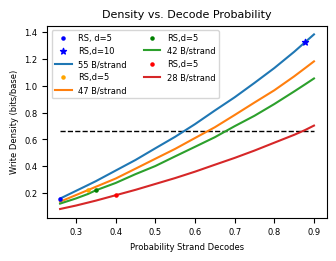

In [41]:
bytes_per_strand = sorted([28,42,47,55],reverse=True)
exist_rates = np.array(sorted(list(np.arange(0.3,0.9,0.05))+[0.878,0.26,0.33,0.40]))
#exist_rates = np.arange(0.3,0.9,0.1)
strand_length=240
file_size=10**6
index_bytes=4
fig,axes = plt.subplots(1,1,figsize=(3.25,2.5),layout="constrained")
for b in bytes_per_strand:
    write_densities=[]
    for e in exist_rates:
        p_index_exists=e
        read_density,write_density=calculate_outer_code(p_index_exists,file_size,b,strand_length=240,d=1,target_MTTF=10**9)
        if read_density!=None:
            write_read_curve.append((read_density,write_density))
            write_densities.append((p_index_exists,write_density))
            if (e==0.878 and b==55) or (e==0.40 and b==28) or(e==0.35 and b==42) or (e==0.33 and b==47) or (b==55 and e==0.26):
                if b==55 and e == 0.878: 
                    color='blue'
                    axes.hlines(write_density/2,min(exist_rates),max(exist_rates),color='k',
                              linestyle='--',linewidth=1)
                    label="RS,d={}".format(10)
                    marker="*"
                if b==55 and e == 0.26:
                    label = "RS, d={}".format(5)
                    marker="."
                    color="blue"
                if b==28: 
                    color='red'
                    label="RS,d={}".format(5)
                    marker="."
                if b==42:
                    color='green'
                    label="RS,d={}".format(5)
                    marker="."
                if b==47:
                    color = 'orange'
                    label="RS,d={}".format(5)
                    marker="."
                print(label)
                axes.scatter([e],[write_density],20,color=color,zorder=10,label=label,marker=marker)
    axes.plot(list(zip(*write_densities))[0],list(zip(*write_densities))[1],linewidth=1.5,
         label="{} B/strand".format(b))
axes.set_xlabel("Probability Strand Decodes",fontsize=6)
axes.set_ylabel("Write Density (bits/base)",fontsize=6)
axes.set_title("Density vs. Decode Probability",fontsize=8)
plt.legend(ncol=2,fontsize=6)
axes.tick_params(axis='both',which='major',labelsize=6)
fig.savefig("density_vs_prob.pdf",format="pdf")


## Nanopore Data

### RS Strand Error Rates after MSA

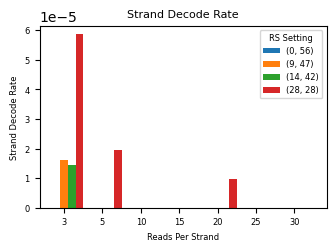

In [42]:
#Calculate Strand Error Rates for RS Codes
#Each plot is for a fault rate, x-axis is read depth, y-axis is strand error rate, lines are for a given RS configuration
bar_width=0.2
#For Reed-solomon pick a design and look at the MSA error rates
cluster_data = RS_cluster_ideal_nano
fig,axes = plt.subplots(1,1,figsize=(3.25,2.4),layout="constrained")
for RS_index,RS_setting in enumerate(sorted(set(cluster_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))),key=lambda x:x[0])):
    if RS_setting == tuple([56,1]): continue
    cluster_data_2 = cluster_data[(cluster_data["encoder::packeted_inner_strand_size"].apply(lambda x:tuple(x)==RS_setting))]
    cluster_data_2=cluster_data_2.fillna(value=0)
    row_data=[]
    for index, row in cluster_data_2.iterrows():
        total_strand_errors =  row["payload::inner_rs::incorrect_strands"]
        total_strands = row["payload::inner_rs::total_strands"]
        n_reads = row["n_success"]
        row_data.append((n_reads,total_strand_errors/total_strands))
    row_data=sorted(row_data,key=lambda x: x[0])
    average_bytes_per_strand = np.array([1-r[1] for r in row_data])
    #print(average_bytes_per_strand)
    #average_bytes_per_strand=average_bytes_per_strand*RS_setting[1]
    index = np.arange(len(row_data))
    axes.bar(index+bar_width*RS_index,average_bytes_per_strand,bar_width,label="{}".format(RS_setting))
    axes.set_xticks(index + bar_width, [r[0] for r in row_data])

axes.set_xlabel("Reads Per Strand",fontsize=6)
axes.set_ylabel("Strand Decode Rate",fontsize=6)
axes.legend(title="RS Setting",fontsize=6,title_fontsize=6)
axes.set_title("Strand Decode Rate",fontsize=8)
axes.tick_params(axis='both',which='major',labelsize=6)

#fig.savefig("strand_efficiency_{}.pdf".format(fault_rate),format="pdf")

In [43]:
combined_frontier={}

### Hedges, No MSA

(0.25, 9)
(0.167, 4)
(0.5, 24)
(0.75, 39)


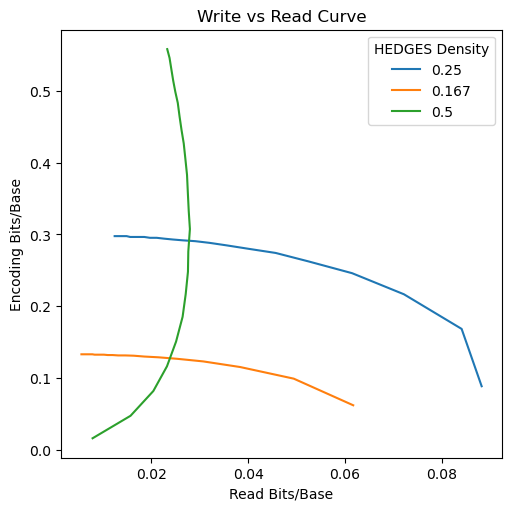

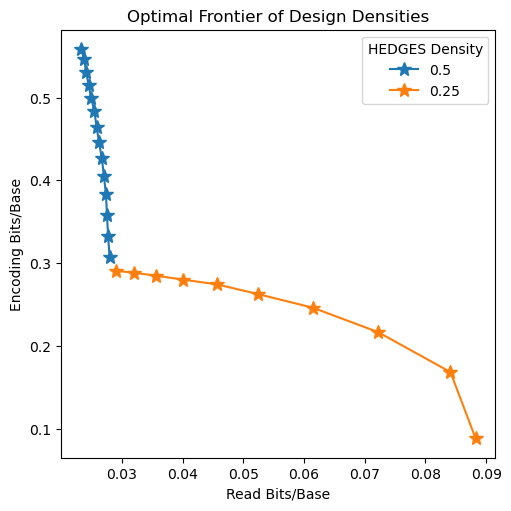

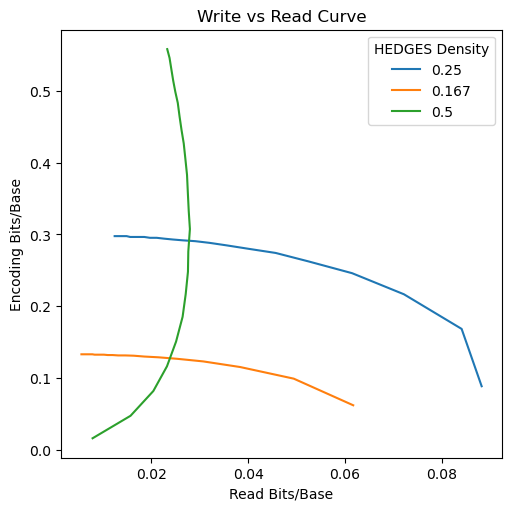

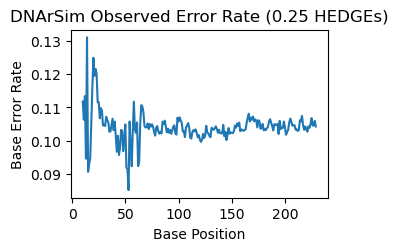

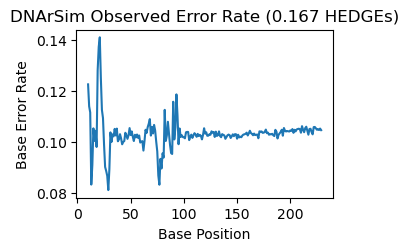

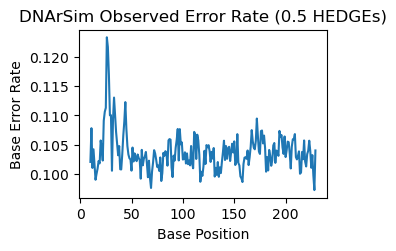

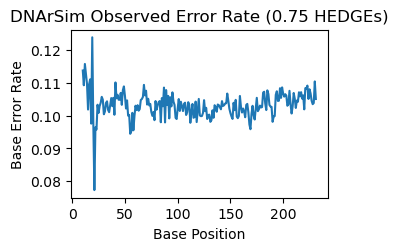

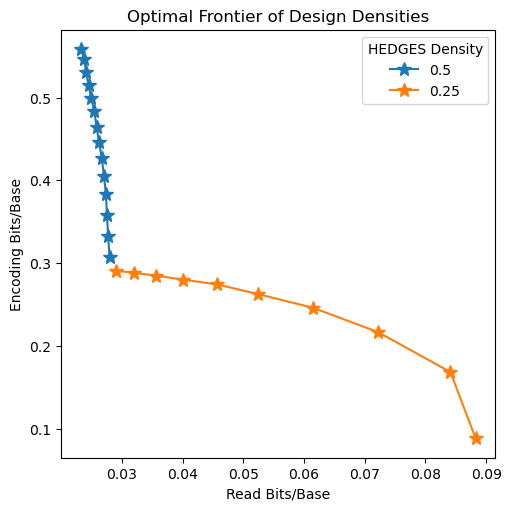

In [47]:
#Write Cost vs Read Cost Curves for Hedges without Clustering, need to determine how much ECC for a given D
p_no_drop_out = 1.0
file_size = 1*10**6 #start with 1 MB files

fault_rate_data = Hedges_no_cluster_nano
main_fig,main_axes = plt.subplots(1,1,figsize=(5,5),layout="constrained")
h_rate_dict={}
for h_rate in set(fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))):
    print(h_rate)
    hedges_data = fault_rate_data[fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x :tuple(x)==h_rate)]
    write_read_curve=[]
    #if h_rate[0]!=0.5: continue
    for index, row in hedges_data.iterrows():
        #get rates of success for strand level
        success_rate = row["payload::hedges::correct_strands"]
        base_error_rate = (row["payload::insertion_edit_errors"]+row["payload::deletion_edit_errors"]+row["payload::substitution_edit_errors"])/row["payload::ed_total_strands"]
        f,axes = plt.subplots(1,1,figsize=(3.25,2.4),layout="constrained")
        axes.plot(range(10,len(base_error_rate)-10),base_error_rate[10:len(base_error_rate)-10])
        axes.set_xlabel("Base Position")
        axes.set_ylabel("Base Error Rate")
        axes.set_title("DNArSim Observed Error Rate ({} HEDGEs)".format(h_rate[0])) 
        total_strands_hedges =row["payload::hedges::total_strands"]
        index_bytes = row["encoder::index_bytes"]
        strand_length = row["payload_strand_length"]
        bytes_per_strand = h_rate[1]
        decode_rate = success_rate/total_strands_hedges
        ideal_strands = int(math.ceil(file_size/bytes_per_strand))
        #sweep over coverage, determine probability that index exists
        for d in range(1,25):
            p_index_exists  = (1-(1-decode_rate)**d)*p_no_drop_out
            read_density,write_density=calculate_outer_code(p_index_exists,file_size,bytes_per_strand,d=d,strand_length=strand_length,target_MTTF=10**9)
            if read_density!=None:
                write_read_curve.append((read_density,write_density))
        #write_read_curve = sorted(write_read_curve,key=lambda x: x[0])
        if len(write_read_curve)==0: continue
        main_axes.plot(list(zip(*write_read_curve))[0],list(zip(*write_read_curve))[1],linewidth=1.5,
         label="{}".format(h_rate[0]))
        h_rate_dict[h_rate[0]]=write_read_curve
main_axes.set_xlabel("Read Bits/Base")
main_axes.set_ylabel("Encoding Bits/Base")
segments = generate_segments(h_rate_dict)
combined_frontier["HEDGES"]=segments
main_axes.legend(title="HEDGES Density")
main_axes.set_title("Write vs Read Curve")
display(main_fig)
#plot Frontiers for each error rate
frontier_fig,frontier_axes = plt.subplots(1,1,figsize=(5,5),layout="constrained")
for s in segments:
    points=segments[s]
    frontier_axes.plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1.5,
             marker='*',markersize=10,label="{}".format(s))
frontier_axes.set_title("Optimal Frontier of Design Densities")
frontier_axes.set_xlabel("Read Bits/Base")
frontier_axes.set_ylabel("Encoding Bits/Base")
frontier_axes.legend(title="HEDGES Density")
display(frontier_fig)
#determine optimal segments for each fault rate


### RS MSA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


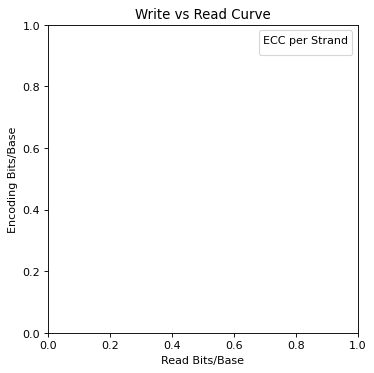

In [15]:
#Write Cost vs Read Cost Curves for Reed Solomon, need to determine how much ECC for a given D

fault_rate_data = RS_cluster_ideal_nano
plt.figure(figsize=(5, 5), dpi=80)
rs_rate_dict={}
for rs_rate in set(fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))):
    rs_data = fault_rate_data[fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x :tuple(x)==rs_rate)]
    write_read_curve=[]
    for d in sorted(set(rs_data["n_success"])):
        d_data = rs_data[rs_data["n_success"]==d]
        for index, row in d_data.iterrows():
            #get rates of success for strand level
            success_rate = row["payload::inner_rs::correct_strands"]
            total_strands =row["payload::inner_rs::total_strands"]
            index_bytes = row["encoder::index_bytes"]
            strand_length = row["payload_strand_length"]
            bytes_per_strand = rs_rate[1]
            if rs_rate[0]==0:
                bytes_per_strand-=1
            decode_rate = success_rate/total_strands
            ideal_strands = int(math.ceil(file_size/bytes_per_strand))
            #sweep over coverage, determine probability that index exists
            p_index_exists  = (1-(1-decode_rate))*p_no_drop_out
            read_density,write_density=calculate_outer_code(p_index_exists,file_size,bytes_per_strand,strand_length=strand_length,d=d,target_MTTF=10**9)
            if read_density !=None:
                write_read_curve.append((read_density,write_density))
    if len(write_read_curve)==0: continue 
    write_read_curve = sorted(write_read_curve,key=lambda x: x[0])
    plt.plot(list(zip(*write_read_curve))[0],list(zip(*write_read_curve))[1],linewidth=1.5,
     label="{}".format(rs_rate[0]))
    rs_rate_dict[rs_rate[0]]=write_read_curve
plt.xlabel("Read Bits/Base")
plt.ylabel("Encoding Bits/Base")
plt.legend(title="ECC per Strand")
plt.title("Write vs Read Curve")
plt.show()
if len(rs_rate_dict)!=0: 
    segments = generate_segments(rs_rate_dict)
    combined_frontier["RS"]=segments
    #plot Frontiers for each error rate
    plt.figure(figsize=(5, 5), dpi=80)
    for s in segments:
        points=segments[s]
        plt.plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1.5,
                 marker='*',label="{}".format(s),markersize=10)
    plt.title("Optimal Frontier of Design Densities")
    plt.xlabel("Read Bits/Base")
    plt.ylabel("Encoding Bits/Base")
    plt.legend(title="ECC per strand")
    plt.show()
   

### Hedges Ideal Cluster

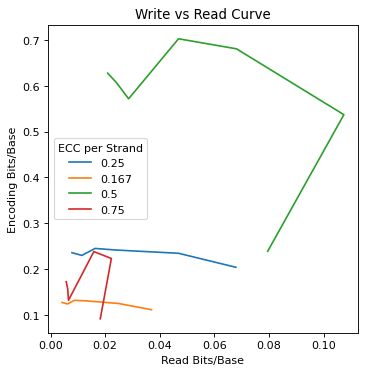

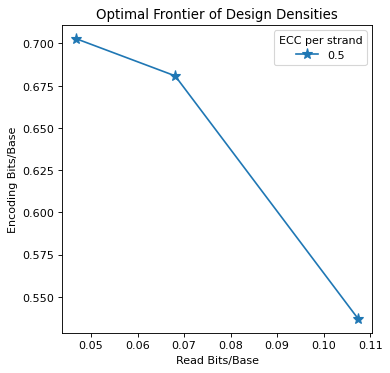

In [16]:
#Write Cost vs Read Cost Curves for Hedges with ideal Clusterin, need to determine how much ECC for a given D
fault_rate_data = Hedges_cluster_ideal_nano
plt.figure(figsize=(5, 5), dpi=80)
rs_rate_dict={}
for rs_rate in set(fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))):
    rs_data = fault_rate_data[fault_rate_data["encoder::packeted_inner_strand_size"].apply(lambda x :tuple(x)==rs_rate)]
    write_read_curve=[]
    for d in sorted(set(rs_data["n_success"])):
        d_data = rs_data[rs_data["n_success"]==d]
        for index, row in d_data.iterrows():
            #get rates of success for strand level
            success_rate = row["payload::hedges::correct_strands"]
            total_strands =row["payload::hedges::total_strands"]
            index_bytes = row["encoder::index_bytes"]
            strand_length = row["payload_strand_length"]
            bytes_per_strand = rs_rate[1]
            decode_rate = success_rate/total_strands
            ideal_strands = int(math.ceil(file_size/bytes_per_strand))
            #sweep over coverage, determine probability that index exists
            p_index_exists  = (1-(1-decode_rate))*p_no_drop_out
            read_density,write_density=calculate_outer_code(p_index_exists,file_size,bytes_per_strand,strand_length=strand_length,d=d,target_MTTF=10**9)
            if read_density!=None:
                write_read_curve.append((read_density,write_density))
    if len(write_read_curve)==0: continue 
    plt.plot(list(zip(*write_read_curve))[0],list(zip(*write_read_curve))[1],linewidth=1.5,
     label="{}".format(rs_rate[0]))
    rs_rate_dict[rs_rate[0]]=write_read_curve
plt.xlabel("Read Bits/Base")
plt.ylabel("Encoding Bits/Base")
if len(rs_rate_dict)!=0: 
    segments = generate_segments(rs_rate_dict)
    combined_frontier["Hedges-MSA"]=segments
    plt.legend(title="ECC per Strand")
    plt.title("Write vs Read Curve")
    plt.show()
    #plot Frontiers for each error rate
    plt.figure(figsize=(5, 5), dpi=80)
    for s in segments:
        points=segments[s]
        plt.plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1.5,
                 marker='*',label="{}".format(s),markersize=10)
    plt.title("Optimal Frontier of Design Densities")
    plt.xlabel("Read Bits/Base")
    plt.ylabel("Encoding Bits/Base")
    plt.legend(title="ECC per strand")
    plt.show()
    #determine optimal segments for each fault rate

### Calculate Total Frontiers

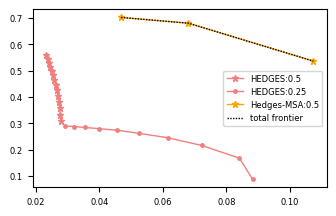

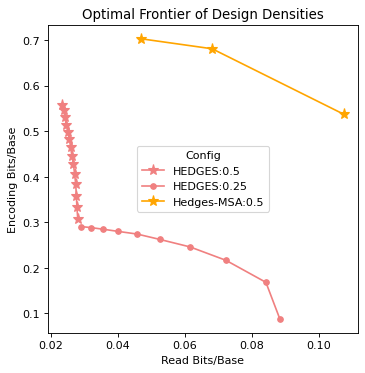

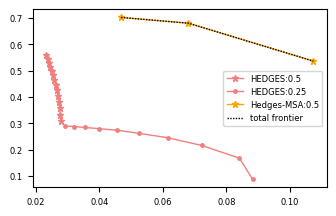

In [17]:
#plot combined frontier
colors = ['lightcoral','orange','limegreen']
marker = ['*','.','^']
fig_fontsize=6
fig,axes = plt.subplots(1,1,figsize=(3.25,2.05),layout="constrained")
plt.figure(figsize=(5, 5), dpi=80)
total_points_dict={"total frontier":[]}
for t_index ,t in enumerate(combined_frontier):
    for f_index, f in enumerate(combined_frontier[t]):
        points = combined_frontier[t][f]
        total_points_dict["total frontier"]+=points
        axes.plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1, label="{}:{}".format(t,f),color=colors[t_index],marker=marker[f_index],markersize=5)
        axes.tick_params(axis='both',which='major',labelsize=6)
        axes.legend(fontsize=6,title_fontsize=6,loc='center')
        plt.plot(list(zip(*points))[0],list(zip(*points))[1],linewidth=1.5,label="{}:{}".format(t,f),color=colors[t_index],marker=marker[f_index],markersize=10)
segment = generate_segments(total_points_dict)
axes.plot(list(zip(*segment["total frontier"]))[0],list(zip(*segment["total frontier"]))[1],linewidth=1,linestyle=(0, (1, 1)), label="total frontier",color='k')
axes.legend(fontsize=6,title_fontsize=6)
plt.legend(title="Config",loc='center')
plt.title("Optimal Frontier of Design Densities")
plt.xlabel("Read Bits/Base")
plt.ylabel("Encoding Bits/Base")
plt.show()
display(fig)
fig.supxlabel("Read Density bits/base",fontsize=8)
fig.supylabel("Write Density bits/base",fontsize=8)
fig.suptitle("Frontier Comparison over Nanopore Channel",fontsize=8)
fig.savefig("frontier_nano.pdf",format='pdf')

### Hedges MSA Error Rates

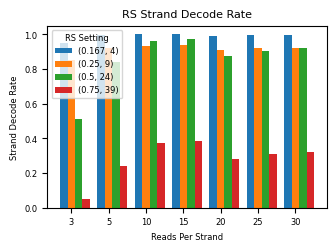

In [18]:
#Calculate Strand Error Rates for RS Codes
#Each plot is for a fault rate, x-axis is read depth, y-axis is strand error rate, lines are for a given RS configuration
bar_width=0.2
#For Reed-solomon pick a design and look at the MSA error rates
cluster_data = Hedges_cluster_ideal_nano
fig,axes = plt.subplots(1,1,figsize=(3.25,2.4),layout="constrained")
for RS_index,RS_setting in enumerate(sorted(set(cluster_data["encoder::packeted_inner_strand_size"].apply(lambda x: tuple(x))),key=lambda x:x[0])):
    if RS_setting == tuple([56,1]): continue
    cluster_data_2 = cluster_data[(cluster_data["encoder::packeted_inner_strand_size"].apply(lambda x:tuple(x)==RS_setting))]
    cluster_data_2=cluster_data_2.fillna(value=0)
    row_data=[]
    for index, row in cluster_data_2.iterrows():
        total_strand_errors =  row["payload::hedges::incorrect_strands"]
        total_strands = row["payload::hedges::total_strands"]
        n_reads = row["n_success"]
        row_data.append((n_reads,total_strand_errors/total_strands))
    row_data=sorted(row_data,key=lambda x: x[0])
    average_bytes_per_strand = np.array([1-r[1] for r in row_data])
    #print(average_bytes_per_strand)
    #average_bytes_per_strand=average_bytes_per_strand*RS_setting[1]
    index = np.arange(len(row_data))
    axes.bar(index+bar_width*RS_index,average_bytes_per_strand,bar_width,label="{}".format(RS_setting))
    axes.set_xticks(index + bar_width, [r[0] for r in row_data])

axes.set_xlabel("Reads Per Strand",fontsize=6)
axes.set_ylabel("Strand Decode Rate",fontsize=6)
axes.legend(title="RS Setting",fontsize=6,title_fontsize=6)
axes.set_title("RS Strand Decode Rate",fontsize=8)
axes.tick_params(axis='both',which='major',labelsize=6)